# Background sense
Our simple visual agent trained with the default clear sky performs quite well spotting UFOs, however, if we [add some clouds](https://assetstore.unity.com/packages/2d/textures-materials/sky/wispy-skybox-21737), the agent gets distracted. Still being able to focus on the contrastive targets, the agent looses focus staring at the clouds.

In this notebook let us teach the agent something about *the background*, maybe, some general sense of it.
For this challenge we let the agent ramble around and get familiar with the environment.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from gym_unity.envs import UnityEnv
from local import train_online
%matplotlib inline

Using TensorFlow backend.


<span style="color:#800">ATTENTION:</span> if you work in editor with non-default scene, you might need to retrain your model later with an executable. Only the default scene is compiled with lights e.c. in Unity editor, the other scenes may look differently (maybe darker) and the models for visual observation may not work as expected after compilation.

In [2]:
env_name = None # use Unity editor with SimpleEnvironment scene active
#env_name = './Exec/Background' # use executable
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


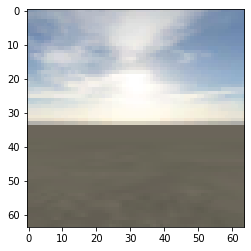

In [3]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [4]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Flat size: {}  Channels: {}'\
      .format(IMG_DIM, np.prod(IMG_DIM), N_CHANNELS))

Image shape: (64, 64, 3)  Flat size: 12288  Channels: 3


## [Variational Autoencoder](https://blog.keras.io/building-autoencoders-in-keras.html)
VAE learns a latent variable model for the input data: the parameters of a probability distribution modeling input data. If we sample points from this distribution, we can generate new data. We also can check if the data sample fits the expectation.

In [5]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Flatten, Concatenate, Reshape, Lambda
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU

In [6]:
LATENT_DIM = 4 # colors, `vertical`, `horizontal`, `sky`, `ground`, `horizon`, ...

In [7]:
from keras import backend as K
from keras.losses import mse, binary_crossentropy

# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# reparameterization trick: z = z_mean + sqrt(var) * epsilon
def sampling(args):
    # sampling from an isotropic unit Gaussian
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
# take an observation + action pair and output `idea`
def encoder(img_dim, latent_dim, name = 'encoder'):
    observed = Input(shape = (np.prod(img_dim),), name = 'observed')
    x = Dense(1024, activation = 'relu')(observed)
    z_mean = Dense(latent_dim, name = 'z_mean')(x)
    z_log_var = Dense(latent_dim, name = 'z_log_var')(x)
    z = Lambda(sampling, output_shape = (latent_dim,), name = 'z')([z_mean, z_log_var])
    return Model(observed, [z, z_mean, z_log_var], name = 'encode')

In [9]:
# instantiate encoder model
encode = encoder(IMG_DIM, LATENT_DIM)
encode.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observed (InputLayer)           (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         12583936    observed[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            4100        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 4)            4100        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [10]:
# take `idea` and restore the image in the original format
def decoder(img_dim, latent_dim, name = 'decoder'):
    latent_input = Input(shape = (latent_dim,), name = 'z_sampling')
    x = Dense(1024, activation = 'relu')(latent_input)
    output = Dense(np.prod(img_dim), activation = 'sigmoid')(x)
    return Model(latent_input, output, name = 'decode')

In [11]:
# instantiate decoder model
decode = decoder(IMG_DIM, LATENT_DIM)
decode.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5120      
_________________________________________________________________
dense_3 (Dense)              (None, 12288)             12595200  
Total params: 12,600,320
Trainable params: 12,600,320
Non-trainable params: 0
_________________________________________________________________


In [12]:
# put it all together
def vae(img_dim, latent_dim):
    # encoder
    encode = encoder(img_dim, latent_dim)
    # decoder
    decode = decoder(img_dim, latent_dim)
    # combined
    observed = Input(shape = (np.prod(img_dim),), name = 'observed')
    z, z_mean, z_log_var = encode(observed)
    averaged = decode(z)
    
    # reconstruction loss + KL-divergence term for regularization
    def vae_loss(observation, vision):
        reconstruction_loss = mse(observation, vision)
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis = -1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)
    
    vae = Model(observed, averaged, name = 'vae')
    vae.compile(optimizer = 'adam', loss = vae_loss)
    return encode, decode, vae

In [13]:
encode, decode, model = vae(IMG_DIM, LATENT_DIM)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
observed (InputLayer)        (None, 12288)             0         
_________________________________________________________________
encode (Model)               [(None, 4), (None, 4), (N 12592136  
_________________________________________________________________
decode (Model)               (None, 12288)             12600320  
Total params: 25,192,456
Trainable params: 25,192,456
Non-trainable params: 0
_________________________________________________________________


In [14]:
def plot_history(log, title = 'Loss history', offset = 0):
    models = [x.split('_')[1] for x in log.keys() if x[:3] == 'val']
    N, n, k = len(log['loss']), len(log['val_loss'])//10, len(models)
    fig, ax = plt.subplots(len(models), figsize = (8, 3 * k), sharex = True)
    for i,m in enumerate(models):
        a = ax if k == 1 else ax[i]
        s = m if m == 'loss' else m +'_loss'
        x = [i for i in range(offset, N)]
        a.plot(x, log['val_'+ s][offset:], color = 'C1', label = 'Validation')
        a.plot(x, log[s][offset:], color = 'C0', label = 'Training', alpha = .6)
        a.hlines(y = np.mean(log['val_'+ s][-n:]), xmin = offset, xmax = N, linestyle = ':')
        a.set_title(title if m == 'loss' else m)
        a.legend()
    plt.show()

In [15]:
# compile data batch for online training (return inputs, targets)
def make_batch(V, A, X):
    # for this model we only need flat visual observations
    flat = (V.shape[0], np.prod(V.shape[1:]))
    return V.reshape(flat), V.reshape(flat)

      1 Loss  trainig: 631948052106.9655 validation: 12470423372.8213
     10 Loss  trainig: 404.1749 validation: 372.2293
     20 Loss  trainig: 85.2301 validation: 84.0410
     30 Loss  trainig: 57.6948 validation: 56.8361
     40 Loss  trainig: 5.0892 validation: 3.1882
     50 Loss  trainig: 0.3472 validation: 0.2942
     60 Loss  trainig: 0.1565 validation: 0.1569
     70 Loss  trainig: 0.1503 validation: 0.1546
     80 Loss  trainig: 0.1600 validation: 0.1441
     90 Loss  trainig: 0.1317 validation: 0.1357
    100 Loss  trainig: 0.1121 validation: 0.1132


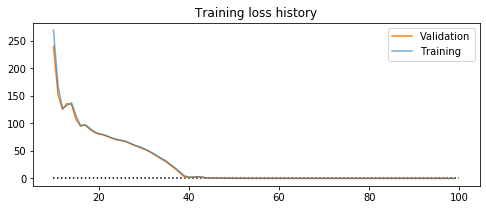

In [16]:
# train the model and plot results
log, V, A, X = train_online(env, model, make_batch)
plot_history(log, 'Training loss history', offset = 10)

In [17]:
sky = np.where(X[:,1] < -30)[0]
horizon = np.where((X[:,1] >= -30) & (X[:,1] < 30))[0]
horizon_exact = np.where(abs(X[:,1]) < 3)[0]
clouds = np.where((abs(X[:,0] - 360) < 20) & (X[:,1] < -5))[0]
ground = np.where(X[:,1] >= 30)[0]

# check representation
len(sky), len(horizon), len(ground)

(79, 126, 51)

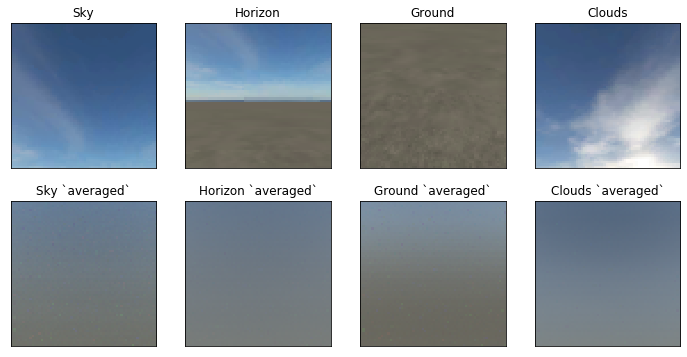

In [18]:
fig, ax = plt.subplots(2, 4, figsize = (12, 6))
indx = [o[rnd.randint(len(o))] for o in [sky, horizon_exact, ground, clouds]]
flat = (1, np.prod(IMG_DIM))
                                             
for j,label in enumerate(['Sky','Horizon','Ground','Clouds']):
    ax[0][j].imshow(V[indx[j],:])
    v = encode.predict(V[indx[j]:indx[j] + 1,:].reshape(flat))[0]
    ax[1][j].imshow(decode.predict(v).reshape(IMG_DIM))
    for i,title in enumerate(['{}','{} `averaged`']):
        ax[i][j].set_title(title.format(label))
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])    
plt.show()

In [19]:
# get learned distributions
sky_mean,_,__ = encode.predict(V[sky,:].reshape((len(sky), np.prod(IMG_DIM))))
horizon_mean,_,__ = encode.predict(V[horizon,:].reshape((len(horizon), np.prod(IMG_DIM))))
ground_mean,_,__ = encode.predict(V[ground,:].reshape((len(ground), np.prod(IMG_DIM))))

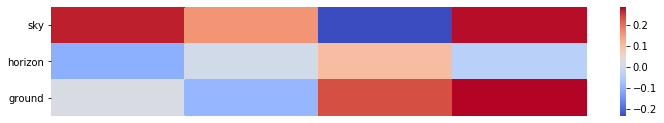

In [20]:
# class encoding heatmap
class_mean = np.empty((3, LATENT_DIM))
class_mean[0,:] = sky_mean.mean(axis = 0)
class_mean[1,:] = horizon_mean.mean(axis = 0)
class_mean[2,:] = ground_mean.mean(axis = 0)

fig, ax = plt.subplots(figsize = (12, 2))
sb.heatmap(class_mean, ax = ax, yticklabels = ['sky','horizon','ground'],
           xticklabels = False, cmap = 'coolwarm')
plt.show()

Sampling pair: [1, 1, 0, 0]


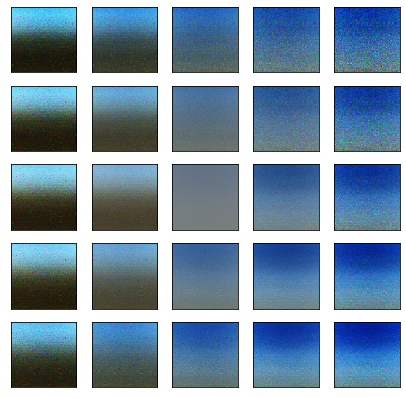

Sampling pair: [1, 0, 1, 0]


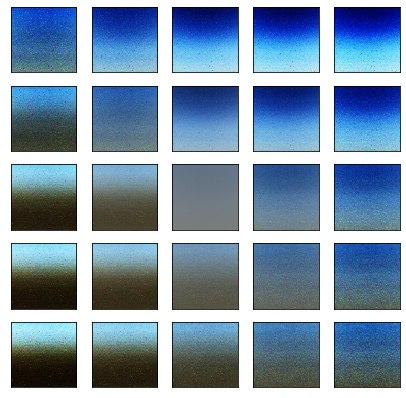

Sampling pair: [1, 0, 0, 1]


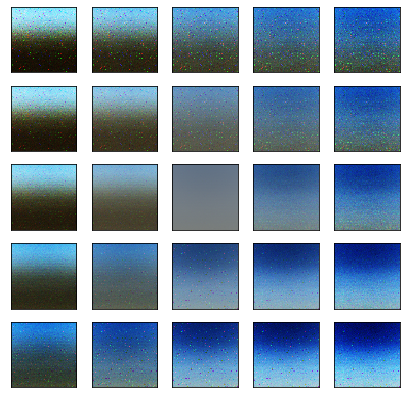

Sampling pair: [0, 1, 1, 0]


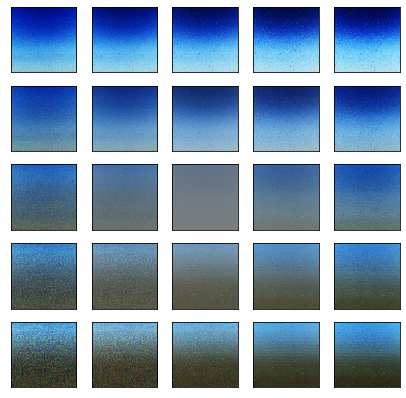

Sampling pair: [0, 1, 0, 1]


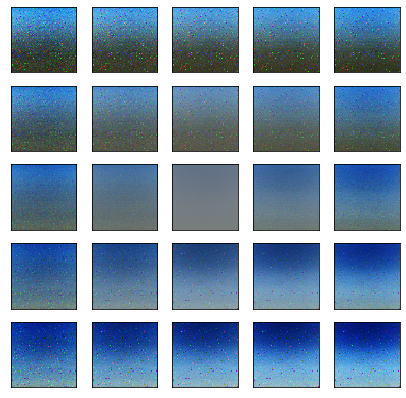

Sampling pair: [0, 0, 1, 1]


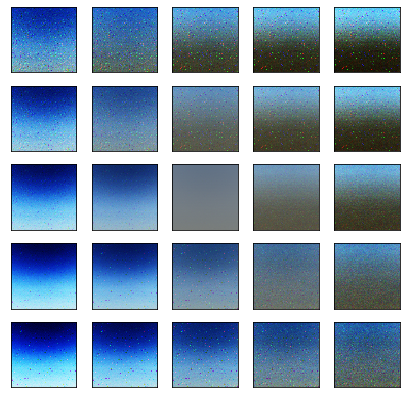

In [21]:
# check if any vertical-horizontal or other sense is present in the pairs
n, s = 5, 20

def permute(seq):
    if len(seq) < 2:
        return [seq]
    D = { tuple([seq[i]] + list(p)): 1 for i in range(len(seq))
             for p in permute(list(seq[:i]) + list(seq[i + 1:])) }
    return [ list(p) for p in D ]

def show_pairs(channel = None, cmap = None):
    for ind in permute([1, 1] + [0 for _ in range(LATENT_DIM - 2)]):
        print('Sampling pair: {}'.format(ind))
        ind[ind.index(1)] = 'h'
        ind[ind.index(1)] = 'v'
        fig, ax = plt.subplots(n, n, figsize = (7, 7))
        for i, v in enumerate(np.linspace(-s, s, n)):
            for j, h in enumerate(np.linspace(-s, s, n)):
                z_sample = np.array([[h if i == 'h' else (v if i == 'v' else 0) for i in ind]])
                x_decoded = decode.predict(z_sample)
                if channel is None:
                    view = x_decoded[0].reshape(IMG_DIM)
                    ax[i][j].imshow(view)
                else:
                    view = x_decoded[0].reshape(IMG_DIM)[:,:,channel]
                    ax[i][j].imshow(view, cmap = cmap)
                ax[i][j].set_xticks([])
                ax[i][j].set_yticks([])
        plt.show()

# check colred
show_pairs()


Pairs for Red channel
Sampling pair: [1, 1, 0, 0]


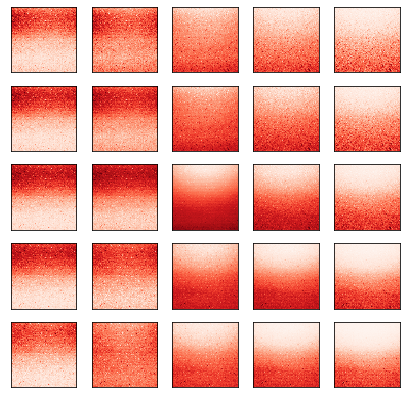

Sampling pair: [1, 0, 1, 0]


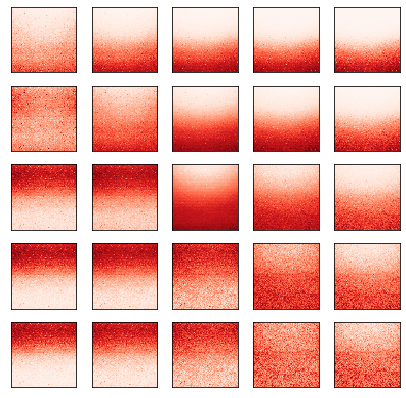

Sampling pair: [1, 0, 0, 1]


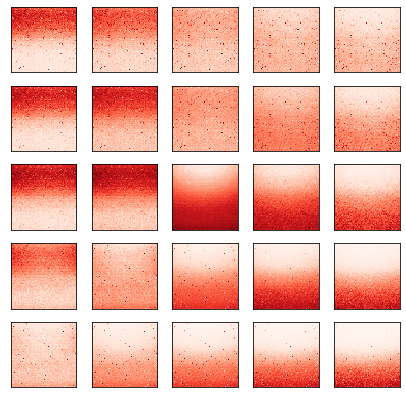

Sampling pair: [0, 1, 1, 0]


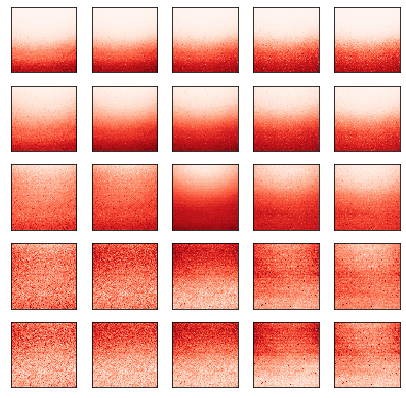

Sampling pair: [0, 1, 0, 1]


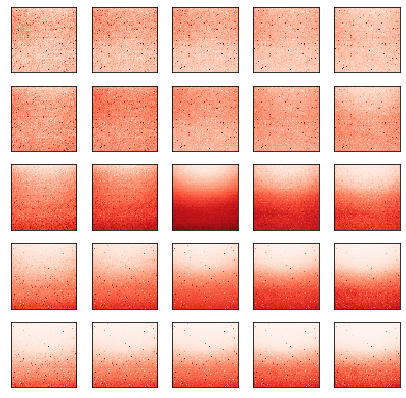

Sampling pair: [0, 0, 1, 1]


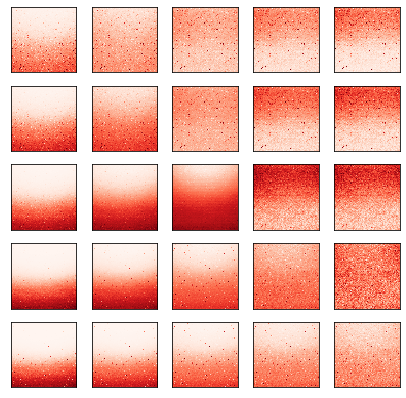


Pairs for Green channel
Sampling pair: [1, 1, 0, 0]


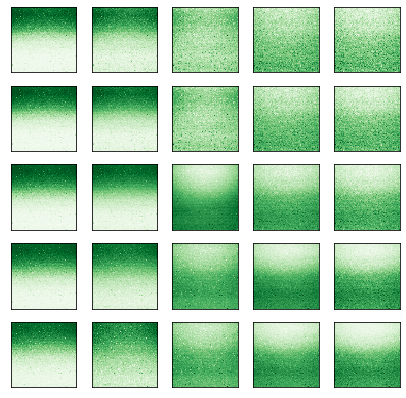

Sampling pair: [1, 0, 1, 0]


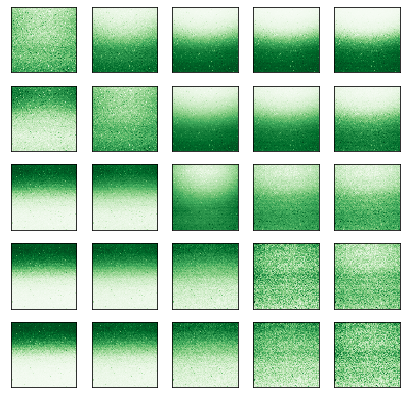

Sampling pair: [1, 0, 0, 1]


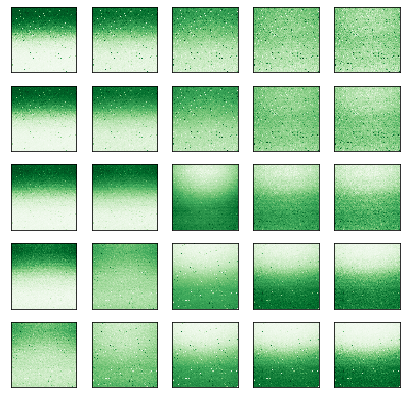

Sampling pair: [0, 1, 1, 0]


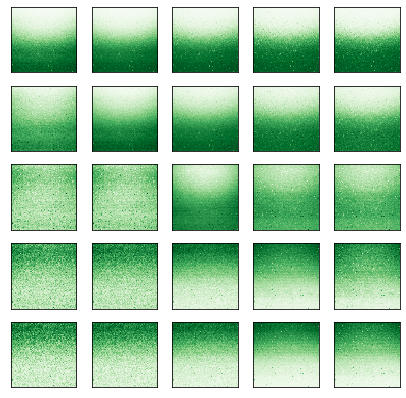

Sampling pair: [0, 1, 0, 1]


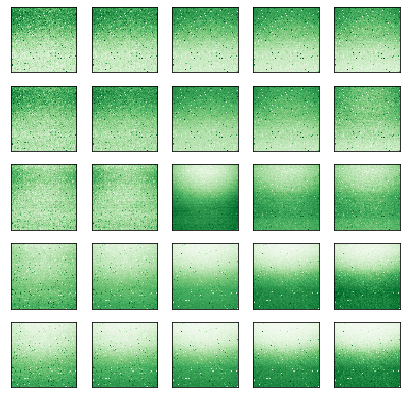

Sampling pair: [0, 0, 1, 1]


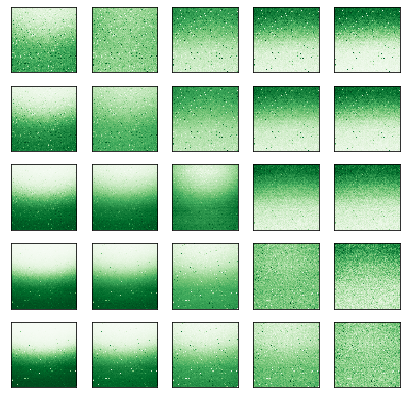


Pairs for Blue channel
Sampling pair: [1, 1, 0, 0]


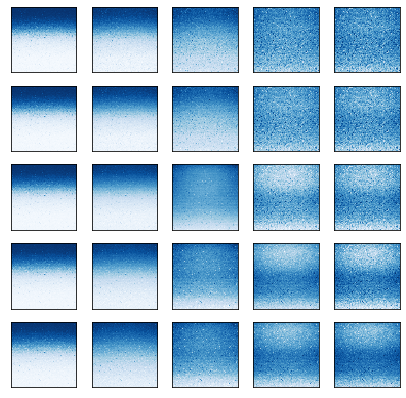

Sampling pair: [1, 0, 1, 0]


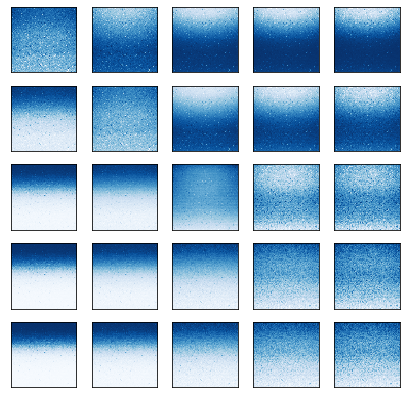

Sampling pair: [1, 0, 0, 1]


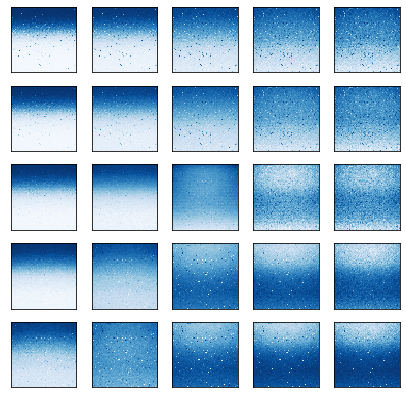

Sampling pair: [0, 1, 1, 0]


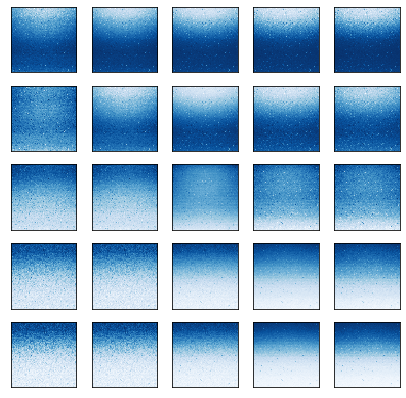

Sampling pair: [0, 1, 0, 1]


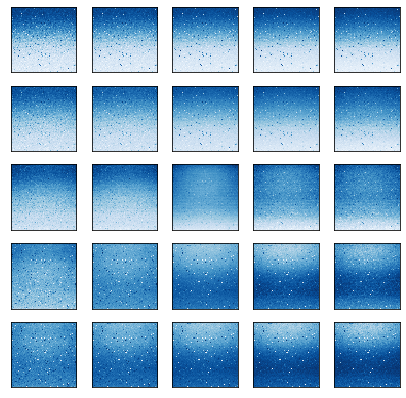

Sampling pair: [0, 0, 1, 1]


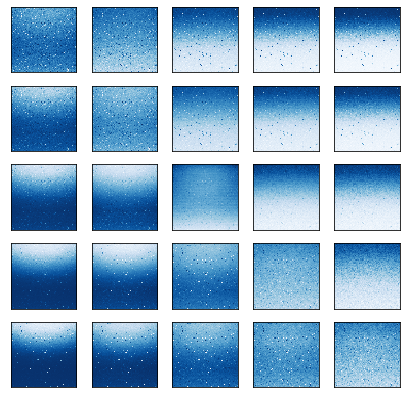

In [22]:
# check by color channel
for i,color in enumerate(['Reds','Greens','Blues']):
    print('\nPairs for {} channel'.format(color[:-1]))
    show_pairs(channel = i, cmap = color)

Our agent definitely learned about the colors of the sky and ground, and maybe something about the horizon.

In [23]:
env.close()